In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Creating a dataframe containing the image path and label

In [10]:
'''
This function reads data from the respective train and test directories
'''
import os
import pandas as pd

def load_data():
    train = pd.read_csv('drive/MyDrive/Pattern Recognition/trainLabels.csv')
    
    train_dir = os.path.join('','drive/MyDrive/Pattern Recognition/train_DR_prepr/scale_300/')
    
    train['file_path'] = train['image'].map(lambda x: os.path.join(train_dir,'{}_p.jpeg'.format(x)))
    
    train['file_name'] = train["image"].apply(lambda x: x + "_p.jpeg")
    
    train['level'] = train['level'].astype(str)
    
    return train

In [11]:
df_train = load_data()
print(df_train.shape,'\n')
df_train.head(6)

(35126, 4) 



,image,level,file_path,file_name
0,10_left,0,drive/MyDrive/Pattern Recognition/train_DR_pre...,10_left_p.jpeg
1,10_right,0,drive/MyDrive/Pattern Recognition/train_DR_pre...,10_right_p.jpeg
2,13_left,0,drive/MyDrive/Pattern Recognition/train_DR_pre...,13_left_p.jpeg
3,13_right,0,drive/MyDrive/Pattern Recognition/train_DR_pre...,13_right_p.jpeg
4,15_left,1,drive/MyDrive/Pattern Recognition/train_DR_pre...,15_left_p.jpeg
5,15_right,2,drive/MyDrive/Pattern Recognition/train_DR_pre...,15_right_p.jpeg


In [12]:
df_train_unbalanced = df_train

## Balancing the data entries by upsampling

In [13]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

New Data Size: 129050 Old Size: 35126


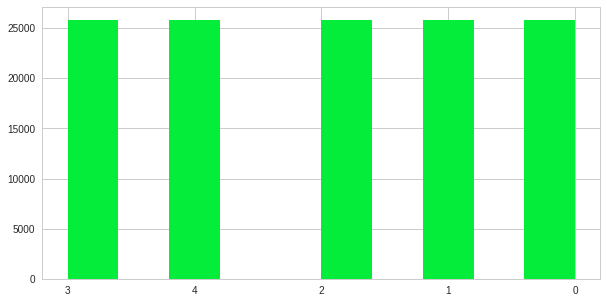

In [14]:
df_train = balance_data(df_train.pivot_table(index='level', aggfunc=len).max().max(),df_train) # oversample such that all classes have the same number of images as the maximum
df_train['level'].hist(figsize = (10, 5))

In [15]:
print(df_train.shape,'\n')
df_train.head(6)
#train_df['level'].hist(figsize = (10, 5))

(129050, 4) 



,image,level,file_path,file_name
0,3868_right,3,drive/MyDrive/Pattern Recognition/train_DR_pre...,3868_right_p.jpeg
1,21205_left,4,drive/MyDrive/Pattern Recognition/train_DR_pre...,21205_left_p.jpeg
2,670_right,4,drive/MyDrive/Pattern Recognition/train_DR_pre...,670_right_p.jpeg
3,32247_right,3,drive/MyDrive/Pattern Recognition/train_DR_pre...,32247_right_p.jpeg
4,25949_right,2,drive/MyDrive/Pattern Recognition/train_DR_pre...,25949_right_p.jpeg
5,22160_right,4,drive/MyDrive/Pattern Recognition/train_DR_pre...,22160_right_p.jpeg


## Initial class distribution

In [16]:
'''This Function Plots a Bar plot of output Classes Distribution'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('level').agg('size').reset_index())
    df_group.columns = ['level','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'level',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

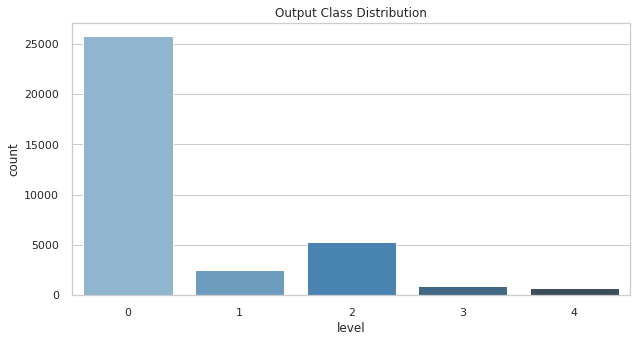

In [17]:
plot_classes(df_train_unbalanced)

# Creating the models 

*About Fractional Max Pooling:*

The pooling fraction α which determines the ratio between the spatial sizes of the input and the output of the pooling layer (N_in/N_out). Regular 2 × 2 max-pooling corresponds to the special case α = 2.

The pooling regions can either be chosen in a random or a pseudorandom
fashion.

The pooling regions can be either disjoint or overlapping. Disjoint regions
are easier to picture, but we find that overlapping regions work better.

Models are generated using the following code:

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 3000
WIDTH = 3000
CANAL = 3
N_CLASSES = 5 
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

Max pooling model:

In [ ]:
import tensorflow as tf
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation, Conv2D, MaxPooling2D, Flatten
from keras import applications


def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = Sequential()
    #base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
   
    #32C5-*-64C3-*-96C3-*-  128C3-*-160C3-*-192C3-*-  224C3-*-256C3-*-228C3-*-  320C2-352C1-5N
    x = Conv2D(filters=32,kernel_size=5,strides=1,activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
   

    x = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu')(x)
    x = Dropout(0.1)(x)
    
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Dropout(0.1)(x)
    
    
   
    
    x = Flatten()(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    print(final_output)
    model = Model(input_tensor, final_output) 

    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='final_output/Softmax:0', description="created by layer 'final_output'")


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 632, 948, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 628, 944, 32)      2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 313, 471, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 311, 469, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 155, 234, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 153, 232, 96)      55392     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 76, 115, 96)       0   

Source: https://analysiscenter.github.io/batchflow/_modules/batchflow/models/tf/layers/pooling.html

Fractional-Max Pooling:

In [66]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as K #pylint: disable=import-error
from tensorflow.keras.layers import Layer


#add_as_function
class FractionalMaxPooling2D (Layer):
    """ Fractional max-pooling layer.

    Parameters
    ----------
    pool_size : float
        pooling ratio (default=1.4142).
    pseudo_random : bool
        Default is False.
    overlapping : bool
        Default is False.
    strides: int
        The strides of the pooling operation.
    padding: str
        'same' or 'valid'
    data_format: str
        'channels_last' or 'channels_first'
    name: str
        Scope name.

    Notes
    -----
    Be aware that it is not thread safe.
    ``tf.nn.fractional_max_pool>`` will likely cause segmentation fault in a multi-threading environment
    (e.g. in a pipeline with prefetch)
    """
    def __init__(self, op, pool_size=1.8, pseudo_random=True, overlapping=True,
                 data_format='channels_last', name=None, **kwargs):
        self.op, self.pseudo_random, self.overlapping = op, pseudo_random, overlapping
        self.pool_size = pool_size
        self.data_format = data_format
        #self.name = name
        self.kwargs = kwargs
        
    def build(self, input_shape):   # Create the state of the layer (weights)
                                    # Create a trainable weight variable for this layer.
                                    # This kind of layer doesn't have any variable
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
        initial_value=w_init(shape=(input_shape[-1], self.units),
                             dtype='float32'),
        trainable=True)
    
        pass

    def __call__(self, inputs): # Defines the computation from inputs to outputs
        dim = inputs.shape.ndims - 2

        if self.op == 'max':
            op = tf.nn.fractional_max_pool
        elif self.op in ['mean', 'average', 'avg']:
            op = tf.nn.fractional_avg_pool

        _pooling_ratio = np.ones(inputs.shape.ndims)
        axis = 1 if self.data_format == 'channels_last' else 2
        _pooling_ratio[axis:axis+dim] = self.pool_size
        _pooling_ratio = list(_pooling_ratio)

        if dim == 1:
            with Lambda(lambda: variable_scope(self.kwargs.get('name') or 'fractional_pooling')): # tf.variable_scope(self.kwargs.get('name') or 'fractional_pooling'):
                axis = 2 if self.data_format == 'channels_last' else -1
                x = tf.expand_dims(inputs, axis=axis)
                _pooling_ratio[axis] = 1
                x, _, _ = op(x, _pooling_ratio, self.pseudo_random, self.overlapping, **self.kwargs)
                x = tf.squeeze(x, [axis])
        elif dim in [2, 3]:
            x, _, _ = op(inputs, _pooling_ratio, self.pseudo_random, self.overlapping, **self.kwargs)
        else:
            raise ValueError("Number of dimensions in the inputs tensor should be 1, 2 or 3, but given %d" % dim)
        

        return x
    



Source: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/3_resnet50(colab).ipynb

In [18]:
BATCH_SIZE = 50 
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 632
WIDTH = 948
CANAL = 3
N_CLASSES = 5 
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [98]:
import tensorflow as tf
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation, Conv2D, MaxPooling2D, Flatten
from keras import applications


def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = Sequential()
   
    # Network architecture: 32C5-*-64C3-*-96C3-*-  128C3-*-160C3-*-192C3-*-  224C3-*-256C3-*-228C3-*-  320C2-352C1-5N -> 16C5-*-32C3-*-64C3-*- 96C3-*-128C3-*-5N
    
    x = Conv2D(filters=16,kernel_size=5,strides=1,activation='relu')(input_tensor)
    x = FractionalMaxPooling2D(op = 'max')(x)
    x = Conv2D(filters=32,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max')(x)
    x = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max')(x)
    x = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max')(x)
    
    '''
    x = Conv2D(filters=128,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max', pool_size=3)(x)
    
    x = Conv2D(filters=160,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max', pool_size=3)(x)
    x = Conv2D(filters=192,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max', pool_size=3)(x)
   
    x = Conv2D(filters=224,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max', pool_size=3)(x)
    x = Conv2D(filters=256,kernel_size=3,strides=1,activation='relu')(x)
    x = FractionalMaxPooling2D(op = 'max', pool_size=3)(x)
    '''
    x = Conv2D(filters=128,kernel_size=3,strides=1,activation='relu')(x)
    x = Dropout(0.1)(x)
    x = FractionalMaxPooling2D(op = 'max')(x)
    #x = Dropout(0.1)(x)
    #x = Conv2D(filters=320,kernel_size=2,strides=1,activation='relu')(x) 
    #x = Dropout(0.1)(x)
    #x = Conv2D(filters=352,kernel_size=1,strides=1,activation='relu')(x)
    x = Dropout(0.1)(x)
    
   
    
    x = Flatten()(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    print(final_output)
    model = Model(input_tensor, final_output) 

    return model

In [99]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='final_output/Softmax:0', description="created by layer 'final_output'")


In [100]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 632, 948, 3)]     0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 628, 944, 16)      1216      
_________________________________________________________________
tf.nn.fractional_max_pool_82 FractionalMaxPool(output= 0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 346, 522, 32)      4640      
_________________________________________________________________
tf.nn.fractional_max_pool_83 FractionalMaxPool(output= 0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 190, 288, 64)      18496     
_________________________________________________________________
tf.nn.fractional_max_pool_84 FractionalMaxPool(output= 0  

## Generating the images data using Image Generator from Keras

Source: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/3_resnet50(colab).ipynb

In [21]:
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img

def img_generator(train): #test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory='drive/My Drive/Pattern Recognition/train_DR_prepr/scale_300',
                                                      x_col="file_name",
                                                      y_col="level",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory='drive/My Drive/Pattern Recognition/train_DR_prepr/scale_300',
                                                      x_col="file_name",
                                                      y_col="level",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory = 'drive/My Drive/Pattern Recognition/test_DR_prepr/scale_300',
                                                      x_col="file_name",
                                                      y_col="level",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=50,
                                                      shuffle=False,
                                                      class_mode='categorical')
    
    return train_generator,valid_generator, test_generator

In [22]:
train_generator,valid_generator,test_generator = img_generator(df_train) #,df_train)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 114104 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 11957 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 114104 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2989 validated image filenames belonging to 5 classes.
Found 2403 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 126647 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Experiments

# Models compilation, training and evaluation

In [23]:
from keras import optimizers

model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=2,  # STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps= 7, #STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
2/2 [==============================] - 89s 53s/step - loss: 2.3884 - accuracy: 0.3833 - val_loss: 1.7482 - val_accuracy: 0.2571
Epoch 2/2
2/2 [==============================] - 65s 46s/step - loss: 1.7715 - accuracy: 0.2333 - val_loss: 1.6268 - val_accuracy: 0.2286


In [24]:
history_warmup

{'accuracy': [0.32499998807907104, 0.22499999403953552],
 'loss': [3.067397356033325, 1.7711780071258545],
 'val_accuracy': [0.2571428716182709, 0.22857142984867096],
 'val_loss': [1.7482482194900513, 1.6267868280410767]}

In [43]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("drive/My Drive/Pattern Recognition/DR models/model_14_3_history_log.csv", append=True)


for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

# define the checkpoint
filepath = "drive/My Drive/Pattern Recognition/DR models/model_14_4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

callback_list = [es, rlrop, checkpoint, csv_logger]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
model.summary()





Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 632, 948, 3)]     0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 628, 944, 16)      1216      
_________________________________________________________________
tf.nn.fractional_max_pool_82 FractionalMaxPool(output= 0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 346, 522, 32)      4640      
_________________________________________________________________
tf.nn.fractional_max_pool_83 FractionalMaxPool(output= 0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 190, 288, 64)      18496     
_________________________________________________________________
tf.nn.fractional_max_pool_84 FractionalMaxPool(output= 0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Class distribution in the balanced train generator:

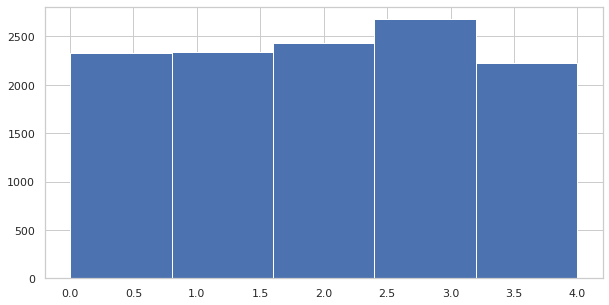

In [20]:
import matplotlib.pyplot as plt

x = train_generator.classes
plt.hist(x, bins = 5)
plt.show()

###Calculating class weights:

In [21]:
zero_num = 0
one_num = 0
two_num = 0
three_num = 0
four_num = 0



for cl in train_generator.classes:
  if cl == 0:
    zero_num += 1
  if cl == 1:
    one_num += 1
  if cl == 2:
    two_num += 1
  if cl == 3:
    three_num += 1
  if cl == 4:
    four_num += 1

In [22]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

total = zero_num + one_num +  two_num + three_num + four_num
weight_for_0 = (1 / zero_num)*(total)/2.0 
weight_for_1 = (1 / one_num)*(total)/2.0
weight_for_2 = (1 / two_num)*(total)/2.0 
weight_for_3 = (1 / three_num)*(total)/2.0
weight_for_4 = (1 / four_num)*(total)/2.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))


Weight for class 0: 2.58
Weight for class 1: 2.57
Weight for class 2: 2.46
Weight for class 3: 2.24
Weight for class 4: 2.70


## Training and testing the best model

FMP = 1.8

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_14.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 576s 23s/step - loss: 4.0387 - accuracy: 0.2160 - val_loss: 1.6133 - val_accuracy: 0.2025

Epoch 00001: loss improved from inf to 4.03873, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_1.h5
Epoch 2/30
25/25 [==============================] - 573s 23s/step - loss: 4.0212 - accuracy: 0.2060 - val_loss: 1.6040 - val_accuracy: 0.2150

Epoch 00002: loss improved from 4.03873 to 4.02117, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_1.h5
Epoch 3/30
25/25 [==============================] - 575s 23s/step - loss: 3.9839 - accuracy: 0.2200 - val_loss: 1.5900 - val_accuracy: 0.2275

Epoch 00003: loss improved from 4.02117 to 3.98390, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_1.h5
Epoch 4/30
25/25 [==============================] - 574s 23s/step - loss: 4.0105 - accuracy: 0.2020 - val_loss: 1.5680 - val_accuracy: 0.2750

Epoch 00004: loss did not improve from 3.98390
Epoc

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_14.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
25/25 [==============================] - 1446s 57s/step - loss: 3.4839 - accuracy: 0.3952 - val_loss: 1.3492 - val_accuracy: 0.4120

Epoch 00001: loss improved from inf to 3.44002, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_2.h5
Epoch 2/30
25/25 [==============================] - 1385s 55s/step - loss: 3.3535 - accuracy: 0.4247 - val_loss: 1.3381 - val_accuracy: 0.4370

Epoch 00002: loss improved from 3.44002 to 3.31382, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_2.h5
Epoch 3/30
25/25 [==============================] - 1377s 55s/step - loss: 3.2687 - accuracy: 0.4413 - val_loss: 1.3148 - val_accuracy: 0.4090

Epoch 00003: loss improved from 3.31382 to 3.22443, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_2.h5
Epoch 4/30
25/25 [==============================] - 1

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_14.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1584s 63s/step - loss: 2.3410 - accuracy: 0.6120 - val_loss: 0.9633 - val_accuracy: 0.6170

Epoch 00001: loss improved from inf to 2.34104, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_3.h5
Epoch 2/30
25/25 [==============================] - 1571s 63s/step - loss: 2.2248 - accuracy: 0.6408 - val_loss: 1.0214 - val_accuracy: 0.5820

Epoch 00002: loss improved from 2.34104 to 2.22484, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_3.h5
Epoch 3/30
25/25 [==============================] - 1622s 65s/step - loss: 2.3098 - accuracy: 0.6368 - val_loss: 0.8514 - val_accuracy: 0.6610

Epoch 00003: loss did not improve from 2.22484
Epoch 4/30
25/25 [==============================] - 1634s 66s/step - loss: 2.1471 - accuracy: 0.6624 - val_loss: 0.8162 - val_accuracy: 0.6750

Epoch 00004: loss improved from 2.22484 to 2.14706, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_3.h5


In [44]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_14.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1578s 63s/step - loss: 1.6662 - accuracy: 0.7368 - val_loss: 0.5813 - val_accuracy: 0.7760

Epoch 00001: loss improved from inf to 1.64264, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_4.h5
Epoch 2/30
25/25 [==============================] - 1623s 65s/step - loss: 1.5422 - accuracy: 0.7466 - val_loss: 0.6791 - val_accuracy: 0.7510

Epoch 00002: loss improved from 1.64264 to 1.58382, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_4.h5
Epoch 3/30
25/25 [==============================] - 1566s 63s/step - loss: 1.4089 - accuracy: 0.7815 - val_loss: 0.6024 - val_accuracy: 0.7570

Epoch 00003: loss improved from 1.58382 to 1.46092, saving model to drive/My Drive/Pattern Recognition/DR models/model_14_4.h5
Epoch 4/30
25/25 [==============================] - 1687s 68s/step - loss: 1.6546 - accuracy: 0.7442 - val_loss: 0.6769 - val_accuracy: 0.7120

Epoch 00004: ReduceLROnPlateau reducing learnin

In [23]:
from keras.models import load_model

model = load_model("drive/My Drive/Pattern Recognition/DR models/model_14.h5")

In [24]:
predictions = model.predict(test_generator)

In [17]:
# model 14_3
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.20819314371371372, 0.21349532931983672, 0.1922382747569619, None)
(0.45607701564380265, 0.45607701564380265, 0.45607701564380265, None)
(0.6443296670710261, 0.4560770156438026, 0.5221874145094481, None)
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       644
           1       0.05      0.11      0.07        57
           2       0.17      0.35      0.23       113
           3       0.00      0.00      0.00         7
           4       0.02      0.10      0.04        10

    accuracy                           0.46       831
   macro avg       0.21      0.21      0.19       831
weighted avg       0.64      0.46      0.52       831



In [ ]:
predictions = model.predict(test_generator)

In [ ]:
# model 14
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.20983774065172386, 0.211884000111861, 0.20184822350670206, None)
(0.5222623345367028, 0.5222623345367028, 0.5222623345367028, None)
(0.6429340057709922, 0.5222623345367028, 0.5733956393658991, None)
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       644
           1       0.06      0.12      0.08        57
           2       0.17      0.21      0.19       113
           3       0.00      0.00      0.00         7
           4       0.02      0.10      0.04        10

    accuracy                           0.52       831
   macro avg       0.21      0.21      0.20       831
weighted avg       0.64      0.52      0.57       831



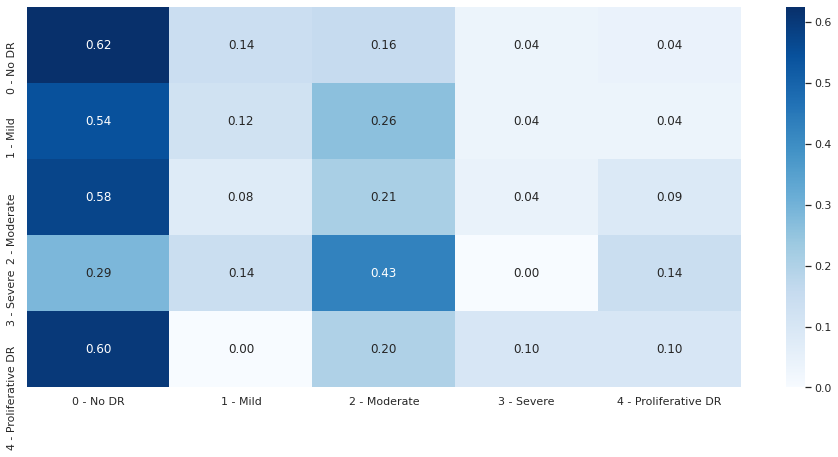

In [47]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

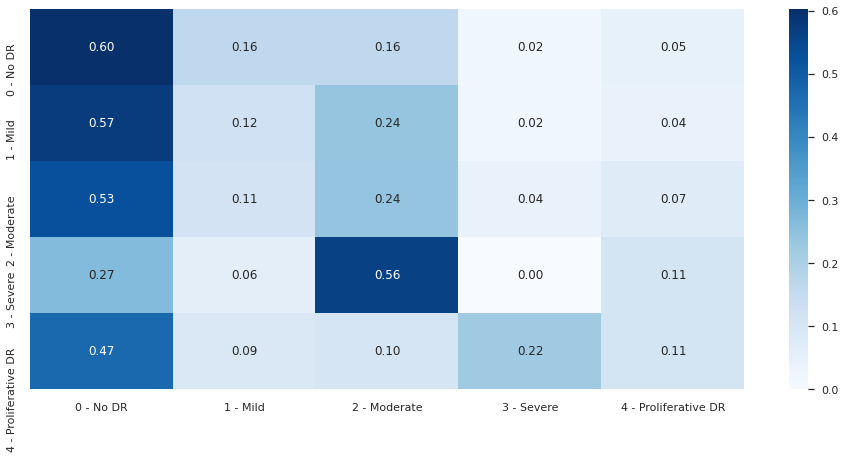

In [26]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

### Analyzing the history of the best model

In [1]:
import pandas as pd
from functools import reduce

df_history1 = pd.read_csv('drive/My Drive/Pattern Recognition/DR models/model_14_history_log.csv')
df_history2 = pd.read_csv('drive/My Drive/Pattern Recognition/DR models/model_14_1_history_log.csv')
df_history3 = pd.read_csv('drive/My Drive/Pattern Recognition/DR models/model_14_2_history_log.csv')
df_history4 = pd.read_csv('drive/My Drive/Pattern Recognition/DR models/model_14_3_history_log.csv')

data_frames = [df_history1, df_history2, df_history3, df_history4]
df_merged = reduce(lambda  left,right: pd.merge(left,right, how='outer'), data_frames)
df_merged

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.223577,4.058310,0.000100,0.185000,1.610960
1,1,0.208000,4.003336,0.000100,0.216667,1.598781
2,0,0.216000,4.038730,0.000100,0.202500,1.613306
3,1,0.206000,4.021168,0.000100,0.215000,1.604038
4,2,0.220000,3.983903,0.000100,0.227500,1.590017
...,...,...,...,...,...,...
61,6,0.810400,1.351391,0.000050,0.796000,0.546631
62,7,0.805600,1.280109,0.000050,0.783000,0.542817
63,8,0.814400,1.296692,0.000050,0.755000,0.584509
64,9,0.811200,1.278538,0.000025,0.800000,0.537990


In [2]:
accuracy_list =[]
loss_list = []
lr_list = []
val_acc_list = []
val_loss_list = []

for idx, row in df_merged.iloc[:,1:2].iterrows():
  accuracy_list.append(row[0])

for idx, row in df_merged.iloc[:,2:3].iterrows():
  loss_list.append(row[0])

for idx, row in df_merged.iloc[:,3:4].iterrows():
  lr_list.append(row[0])

for idx, row in df_merged.iloc[:,4:5].iterrows():
  val_acc_list.append(row[0])

for idx, row in df_merged.iloc[:,5:6].iterrows():
  val_loss_list.append(row[0])



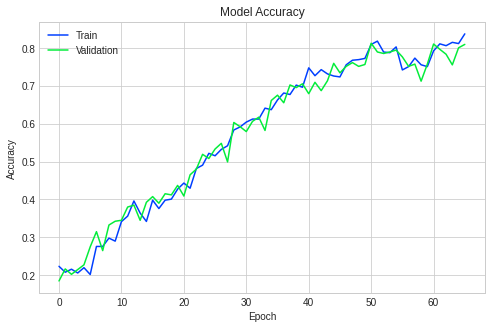

In [5]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
import matplotlib.pyplot as plt
plt.style.use(['seaborn-bright', 'seaborn-whitegrid'])
plt.figure(figsize=(8,5))

plt.plot(accuracy_list)
plt.plot(val_acc_list)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', useOffset=False)
plt.show()

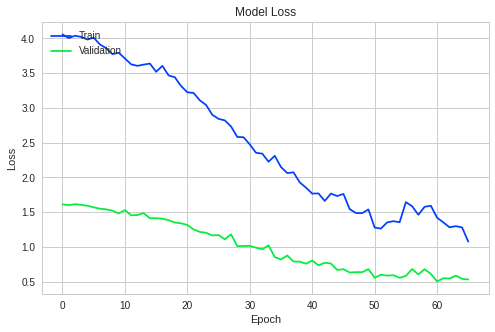

In [9]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
import matplotlib.pyplot as plt
plt.style.use(['seaborn-bright', 'seaborn-whitegrid'])
plt.figure(figsize=(8,5))

plt.plot(loss_list)
plt.plot(val_loss_list)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', useOffset=False)
plt.show()

## Previous model experiments

Validation_steps = 20, start over with batch=20.

In [21]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_10_final.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
25/25 [==============================] - 480s 18s/step - loss: 4.0325 - accuracy: 0.2388 - val_loss: 1.6087 - val_accuracy: 0.1975

Epoch 00001: loss improved from inf to 4.04518, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_3.h5
Epoch 2/30
25/25 [==============================] - 454s 18s/step - loss: 4.0337 - accuracy: 0.1748 - val_loss: 1.6076 - val_accuracy: 0.1850

Epoch 00002: loss improved from 4.04518 to 4.02804, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_3.h5
Epoch 3/30
25/25 [==============================] - 452s 18s/step - loss: 4.0352 - accuracy: 0.2030 - val_loss: 1.6092 - val_accuracy: 0.2650

Epoch 00003: loss did not improve from 4.02804
Epoch 4/30
25/25 [==============================] - 448s 18s/step - loss: 4.0256 - accuracy: 0.2238 - val_loss: 1.6082 - val_accuracy: 0

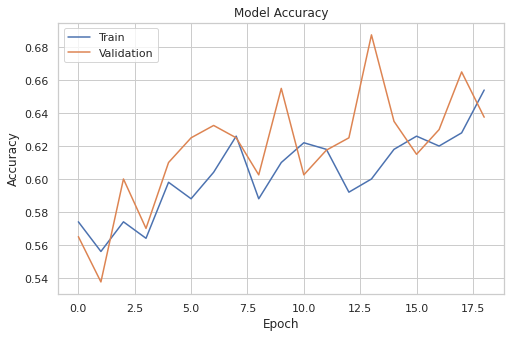

In [ ]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

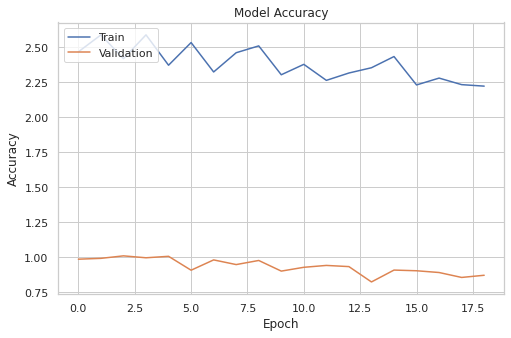

In [ ]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['loss'])
plt.plot(history_finetunning['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [39]:
model = load_model("drive/My Drive/Pattern Recognition/DR models/model_10_final.h5")

In [40]:
predictions = model.predict(test_generator)

With batch=20, FMP=2.0:

In [41]:
# model 10_final
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.2061538461538462, 0.1498364803891221, 0.07692551811852286, None)
(0.10469314079422383, 0.10469314079422383, 0.10469314079422383, None)
(0.6661513216025852, 0.10469314079422383, 0.14445213325117168, None)
              precision    recall  f1-score   support

           0       0.83      0.08      0.15       644
           1       0.05      0.02      0.03        57
           2       0.14      0.25      0.18       113
           3       0.00      0.00      0.00         7
           4       0.01      0.40      0.03        10

    accuracy                           0.10       831
   macro avg       0.21      0.15      0.08       831
weighted avg       0.67      0.10      0.14       831



In [23]:
import pickle

a_file = open("drive/MyDrive/Pattern Recognition/hft_10_3.pkl", "wb")
pickle.dump(history_finetunning, a_file)
a_file.close()

a_file = open("drive/MyDrive/Pattern Recognition/hft_10_3.pkl", "rb")
output = pickle.load(a_file)
print(output)

{'loss': [4.0451836585998535, 4.028039932250977, 4.038781642913818, 4.026873588562012, 4.010360240936279, 4.031231880187988, 3.9968323707580566, 4.017909526824951, 3.9627175331115723, 3.9281442165374756, 3.9509875774383545, 3.8856496810913086, 3.9274260997772217, 3.8950817584991455, 3.9053728580474854, 3.8573811054229736, 3.8077280521392822, 3.8255579471588135, 3.817826271057129, 3.8420932292938232, 3.7509799003601074, 3.75178861618042, 3.732388496398926, 3.775348424911499, 3.71639347076416, 3.74277400970459, 3.759873151779175, 3.744926691055298], 'accuracy': [0.20800000429153442, 0.18000000715255737, 0.19200000166893005, 0.20999999344348907, 0.22599999606609344, 0.21199999749660492, 0.2460000067949295, 0.2460000067949295, 0.2619999945163727, 0.26600000262260437, 0.2980000078678131, 0.29600000381469727, 0.24799999594688416, 0.2759999930858612, 0.27799999713897705, 0.3179999887943268, 0.3440000116825104, 0.29600000381469727, 0.3140000104904175, 0.3019999861717224, 0.3160000145435333, 0.

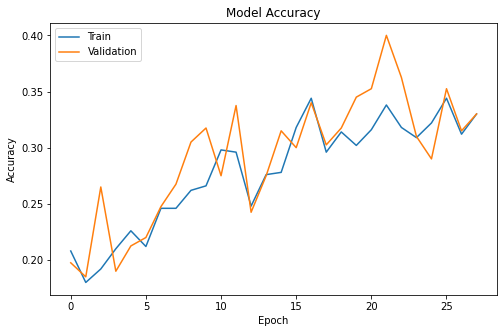

In [24]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

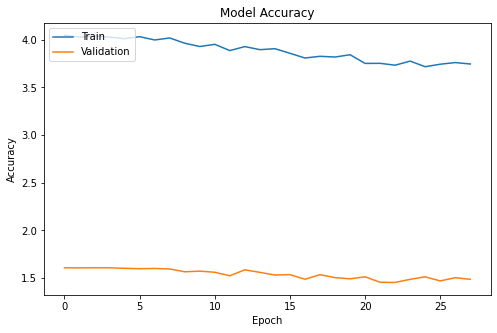

In [25]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['loss'])
plt.plot(history_finetunning['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [28]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_10_final_1.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 498s 20s/step - loss: 3.6530 - accuracy: 0.3620 - val_loss: 1.4659 - val_accuracy: 0.3467

Epoch 00001: loss improved from 3.71639 to 3.65301, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_3.h5
Epoch 2/30
25/25 [==============================] - 473s 19s/step - loss: 3.7522 - accuracy: 0.3040 - val_loss: 1.4482 - val_accuracy: 0.3433

Epoch 00002: loss did not improve from 3.65301
Epoch 3/30
25/25 [==============================] - 497s 20s/step - loss: 3.6036 - accuracy: 0.3780 - val_loss: 1.5001 - val_accuracy: 0.2950

Epoch 00003: loss improved from 3.65301 to 3.60357, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_3.h5
Epoch 4/30
25/25 [==============================] - 469s 19s/step - loss: 3.7368 - accuracy: 0.3516 - val_loss: 1.4985 - val_accuracy: 0.3200

Epoch 00004: loss did not improve from 3.60357
Epoch 5/30
25/25 [==============================] - 474s 19s/step - loss: 3.6795

In [35]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_10_additional.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
25/25 [==============================] - 453s 18s/step - loss: 2.5665 - accuracy: 0.5688 - val_loss: 0.9864 - val_accuracy: 0.5650

Epoch 00001: loss improved from inf to 2.46529, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_2.h5
Epoch 2/30
25/25 [==============================] - 510s 21s/step - loss: 2.5304 - accuracy: 0.5662 - val_loss: 0.9923 - val_accuracy: 0.5375

Epoch 00002: loss did not improve from 2.46529
Epoch 3/30
25/25 [==============================] - 449s 18s/step - loss: 2.3939 - accuracy: 0.5567 - val_loss: 1.0101 - val_accuracy: 0.6000

Epoch 00003: loss improved from 2.46529 to 2.41671, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_2.h5
Epoch 4/30
25/25 [==============================] - 450s 18s/step - loss: 2.4823 - accuracy: 0.5876 - val_loss: 0.9964 - val_accuracy: 0

In [42]:
import pickle

a_file = open("drive/MyDrive/Pattern Recognition/hft_10_2.pkl", "wb")
pickle.dump(history_finetunning, a_file)
a_file.close()

a_file = open("drive/MyDrive/Pattern Recognition/hft_10_2.pkl", "rb")
output = pickle.load(a_file)
print(output)

{'loss': [2.4652905464172363, 2.586071252822876, 2.4167113304138184, 2.5864317417144775, 2.369879961013794, 2.5314230918884277, 2.321747064590454, 2.4589762687683105, 2.507697820663452, 2.3018085956573486, 2.3760828971862793, 2.2618179321289062, 2.3143062591552734, 2.351877450942993, 2.4317188262939453, 2.229215383529663, 2.278012275695801, 2.2313339710235596, 2.2206759452819824], 'accuracy': [0.5740000009536743, 0.5559999942779541, 0.5740000009536743, 0.5640000104904175, 0.5979999899864197, 0.5879999995231628, 0.6040816307067871, 0.6259999871253967, 0.5879999995231628, 0.6100000143051147, 0.621999979019165, 0.6179999709129333, 0.5920000076293945, 0.6000000238418579, 0.6179999709129333, 0.6259999871253967, 0.6200000047683716, 0.628000020980835, 0.6539999842643738], 'val_loss': [0.9864193797111511, 0.992320716381073, 1.0101368427276611, 0.9964354634284973, 1.006883978843689, 0.9077864289283752, 0.9813078045845032, 0.9479377865791321, 0.977236807346344, 0.9014028906822205, 0.928534269332

Max_Pooling:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_13.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 790s 31s/step - loss: 3.4428 - accuracy: 0.4060 - val_loss: 1.3934 - val_accuracy: 0.3750

Epoch 00001: loss improved from inf to 3.44280, saving model to drive/My Drive/Pattern Recognition/DR models/model_12_2.h5
Epoch 2/30
25/25 [==============================] - 790s 32s/step - loss: 3.4774 - accuracy: 0.3800 - val_loss: 1.4042 - val_accuracy: 0.3475

Epoch 00002: loss did not improve from 3.44280
Epoch 3/30
25/25 [==============================] - 782s 31s/step - loss: 3.5542 - accuracy: 0.3660 - val_loss: 1.3811 - val_accuracy: 0.4125

Epoch 00003: loss did not improve from 3.44280
Epoch 4/30
25/25 [==============================] - 779s 31s/step - loss: 3.4577 - accuracy: 0.4040 - val_loss: 1.3901 - val_accuracy: 0.3850

Epoch 00004: loss did not improve from 3.44280
Epoch 5/30
25/25 [==============================] - 791s 32s/step - loss: 3.5487 - accuracy: 0.3520 - val_loss: 1.3868 - val_accuracy: 0.3900

Epoch 00005: loss did

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_12.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 622s 25s/step - loss: 4.0215 - accuracy: 0.2256 - val_loss: 1.6135 - val_accuracy: 0.1950

Epoch 00001: loss improved from inf to 4.02258, saving model to drive/My Drive/Pattern Recognition/DR models/model_12_1.h5
Epoch 2/30
25/25 [==============================] - 618s 25s/step - loss: 4.0003 - accuracy: 0.1631 - val_loss: 1.6034 - val_accuracy: 0.1975

Epoch 00002: loss improved from 4.02258 to 4.01681, saving model to drive/My Drive/Pattern Recognition/DR models/model_12_1.h5
Epoch 3/30
25/25 [==============================] - 616s 25s/step - loss: 4.0020 - accuracy: 0.2225 - val_loss: 1.5839 - val_accuracy: 0.1950

Epoch 00003: loss improved from 4.01681 to 3.99235, saving model to drive/My Drive/Pattern Recognition/DR models/model_12_1.h5
Epoch 4/30
25/25 [==============================] - 612s 25s/step - loss: 4.0238 - accuracy: 0.2754 - val_loss: 1.5733 - val_accuracy: 0.2425

Epoch 00004: loss did not improve from 3.99235
Epoc

Batch_size = 50:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_8.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
25/25 [==============================] - 1238s 49s/step - loss: 3.1149 - accuracy: 0.4670 - val_loss: 1.2279 - val_accuracy: 0.4600

Epoch 00001: loss improved from inf to 3.08811, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_2.h5
Epoch 2/40
25/25 [==============================] - 1231s 49s/step - loss: 3.0381 - accuracy: 0.4758 - val_loss: 1.2370 - val_accuracy: 0.4450

Epoch 00002: loss improved from 3.08811 to 3.08081, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_2.h5
Epoch 3/40
25/25 [==============================] - 1235s 50s/step - loss: 3.1096 - accuracy: 0.4606 - val_loss: 1.2377 - val_accuracy: 0.4750

Epoch 00003: loss did not improve from 3.08081
Epoch 4/40
25/25 [==============================] - 1230s 49s/step - loss: 3.1019 - accuracy: 0.4703 - val_loss: 1.1871 - val_accuracy: 0.5110

Epoch 00004: loss improved from 3.08081 to 3.04920, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_2.h5
Epo

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_8.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
25/25 [==============================] - 1311s 52s/step - loss: 4.0380 - accuracy: 0.2096 - val_loss: 1.6100 - val_accuracy: 0.1920

Epoch 00001: loss improved from inf to 4.03802, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_1.h5
Epoch 2/40
25/25 [==============================] - 1298s 52s/step - loss: 4.0307 - accuracy: 0.2192 - val_loss: 1.6105 - val_accuracy: 0.2350

Epoch 00002: loss improved from 4.03802 to 4.03072, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_1.h5
Epoch 3/40
25/25 [==============================] - 1285s 52s/step - loss: 4.0185 - accuracy: 0.2152 - val_loss: 1.6061 - val_accuracy: 0.2070

Epoch 00003: loss improved from 4.03072 to 4.01850, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_1.h5
Epoch 4/40
25/25 [==============================] - 1262s 51s/step - loss: 4.0263 - accuracy: 0.2570 - val_loss: 1.6028 - val_accuracy: 0.3100

Epoch 00004: loss did not improve from 4.01850
Epo

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_8.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1244s 50s/step - loss: 2.7756 - accuracy: 0.5148 - val_loss: 1.0859 - val_accuracy: 0.5610

Epoch 00001: loss improved from inf to 2.77564, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_3.h5
Epoch 2/30
25/25 [==============================] - 1235s 50s/step - loss: 2.8064 - accuracy: 0.5088 - val_loss: 1.1378 - val_accuracy: 0.5280

Epoch 00002: loss did not improve from 2.77564
Epoch 3/30
25/25 [==============================] - 1232s 49s/step - loss: 2.8078 - accuracy: 0.5240 - val_loss: 1.1151 - val_accuracy: 0.5510

Epoch 00003: loss did not improve from 2.77564
Epoch 4/30
25/25 [==============================] - 1230s 49s/step - loss: 2.6751 - accuracy: 0.5408 - val_loss: 1.0699 - val_accuracy: 0.5340

Epoch 00004: loss improved from 2.77564 to 2.67509, saving model to drive/My Drive/Pattern Recognition/DR models/model_8_3.h5
Epoch 5/30
25/25 [==============================] - 1233s 50s/step - loss: 2.7541 

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_9.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1265s 51s/step - loss: 2.7740 - accuracy: 0.5271 - val_loss: 1.0898 - val_accuracy: 0.5390

Epoch 00001: loss improved from inf to 2.67567, saving model to drive/My Drive/Pattern Recognition/DR models/model_9_1.h5
Epoch 2/30
25/25 [==============================] - 1262s 51s/step - loss: 2.8350 - accuracy: 0.5236 - val_loss: 1.0992 - val_accuracy: 0.5310

Epoch 00002: loss did not improve from 2.67567
Epoch 3/30
25/25 [==============================] - 1254s 50s/step - loss: 2.5613 - accuracy: 0.5686 - val_loss: 1.0638 - val_accuracy: 0.5420

Epoch 00003: loss improved from 2.67567 to 2.54925, saving model to drive/My Drive/Pattern Recognition/DR models/model_9_1.h5
Epoch 4/30
25/25 [==============================] - 1253s 50s/step - loss: 2.5438 - accuracy: 0.5522 - val_loss: 1.0538 - val_accuracy: 0.5510

Epoch 00004: loss did not improve from 2.54925
Epoch 5/30
25/25 [==============================] - 1258s 51s/step - loss: 2.6654 

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=20,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_9.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1254s 50s/step - loss: 2.5715 - accuracy: 0.5768 - val_loss: 1.0631 - val_accuracy: 0.5790

Epoch 00001: loss improved from inf to 2.57150, saving model to drive/My Drive/Pattern Recognition/DR models/model_9_2.h5
Epoch 2/30
25/25 [==============================] - 1314s 53s/step - loss: 2.5358 - accuracy: 0.5872 - val_loss: 1.0092 - val_accuracy: 0.5860

Epoch 00002: loss improved from 2.57150 to 2.53583, saving model to drive/My Drive/Pattern Recognition/DR models/model_9_2.h5
Epoch 3/30
25/25 [==============================] - 1315s 53s/step - loss: 2.5806 - accuracy: 0.5648 - val_loss: 0.9878 - val_accuracy: 0.6030

Epoch 00003: loss did not improve from 2.53583
Epoch 4/30
25/25 [==============================] - 1233s 49s/step - loss: 2.6268 - accuracy: 0.5796 - val_loss: 1.0001 - val_accuracy: 0.6010

Epoch 00004: loss did not improve from 2.53583
Epoch 5/30
25/25 [==============================] - 1301s 52s/step - loss: 2.5478 

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_10.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1318s 52s/step - loss: 2.4647 - accuracy: 0.5945 - val_loss: 0.9509 - val_accuracy: 0.5987

Epoch 00001: loss improved from inf to 2.54415, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_1.h5
Epoch 2/30
25/25 [==============================] - 1223s 49s/step - loss: 2.5741 - accuracy: 0.5961 - val_loss: 0.9501 - val_accuracy: 0.6033

Epoch 00002: loss improved from 2.54415 to 2.50622, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_1.h5
Epoch 3/30
25/25 [==============================] - 1210s 49s/step - loss: 2.3823 - accuracy: 0.5996 - val_loss: 0.9548 - val_accuracy: 0.6087

Epoch 00003: loss improved from 2.50622 to 2.42669, saving model to drive/My Drive/Pattern Recognition/DR models/model_10_1.h5
Epoch 4/30
25/25 [==============================] - 1203s 48s/step - loss: 2.3230 - accuracy: 0.6159 - val_loss: 0.9655 - val_accuracy: 0.5860

Epoch 00004: loss did not improve from 2.42669


In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_11.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1407s 57s/step - loss: 2.5612 - accuracy: 0.5745 - val_loss: 0.9458 - val_accuracy: 0.6160

Epoch 00001: loss improved from inf to 2.46177, saving model to drive/My Drive/Pattern Recognition/DR models/model_11_1.h5
Epoch 2/30
25/25 [==============================] - 1424s 57s/step - loss: 2.4388 - accuracy: 0.6144 - val_loss: 0.9532 - val_accuracy: 0.6020

Epoch 00002: loss improved from 2.46177 to 2.42646, saving model to drive/My Drive/Pattern Recognition/DR models/model_11_1.h5
Epoch 3/30
25/25 [==============================] - 1371s 55s/step - loss: 2.3234 - accuracy: 0.6295 - val_loss: 0.9727 - val_accuracy: 0.5720

Epoch 00003: loss improved from 2.42646 to 2.37654, saving model to drive/My Drive/Pattern Recognition/DR models/model_11_1.h5
Epoch 4/30
25/25 [==============================] - 1357s 55s/step - loss: 2.5109 - accuracy: 0.5987 - val_loss: 0.9320 - val_accuracy: 0.6053

Epoch 00004: loss did not improve from 2.37654


In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=25,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_11.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 1394s 56s/step - loss: 2.3818 - accuracy: 0.6052 - val_loss: 0.8775 - val_accuracy: 0.6480

Epoch 00001: loss improved from inf to 2.41103, saving model to drive/My Drive/Pattern Recognition/DR models/model_11_2.h5
Epoch 2/30
25/25 [==============================] - 1394s 56s/step - loss: 2.2723 - accuracy: 0.6269 - val_loss: 0.8852 - val_accuracy: 0.6373

Epoch 00002: loss improved from 2.41103 to 2.34355, saving model to drive/My Drive/Pattern Recognition/DR models/model_11_2.h5
Epoch 3/30
25/25 [==============================] - 1372s 55s/step - loss: 2.2922 - accuracy: 0.6147 - val_loss: 0.8969 - val_accuracy: 0.6353

Epoch 00003: loss improved from 2.34355 to 2.30222, saving model to drive/My Drive/Pattern Recognition/DR models/model_11_2.h5
Epoch 4/30
25/25 [==============================] - 1411s 57s/step - loss: 2.2887 - accuracy: 0.5951 - val_loss: 0.8870 - val_accuracy: 0.6347

Epoch 00004: ReduceLROnPlateau reducing learnin

With no learning rate set and less steps per epoch and validation steps and oversampling:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=50,
                                          validation_data=valid_generator,
                                          validation_steps=50,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_4.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
50/50 [==============================] - 381s 8s/step - loss: 4.0451 - accuracy: 0.2379 - val_loss: 1.6096 - val_accuracy: 0.2275
Epoch 2/40
50/50 [==============================] - 367s 7s/step - loss: 4.0047 - accuracy: 0.2019 - val_loss: 1.6086 - val_accuracy: 0.2175
Epoch 3/40
50/50 [==============================] - 365s 7s/step - loss: 4.0341 - accuracy: 0.1874 - val_loss: 1.6064 - val_accuracy: 0.2450
Epoch 4/40
50/50 [==============================] - 363s 7s/step - loss: 4.0300 - accuracy: 0.2046 - val_loss: 1.6009 - val_accuracy: 0.1875
Epoch 5/40
50/50 [==============================] - 363s 7s/step - loss: 3.9832 - accuracy: 0.2401 - val_loss: 1.6080 - val_accuracy: 0.2125
Epoch 6/40
50/50 [==============================] - 364s 7s/step - loss: 4.0112 - accuracy: 0.1741 - val_loss: 1.6068 - val_accuracy: 0.2300
Epoch 7/40
50/50 [==============================] - 365s 7s/step - loss: 4.0211 - accuracy: 0.1989 - val_loss: 1.6092 - val_accuracy: 0.1900

Epoch 00007:

In [30]:
model = load_model("drive/My Drive/Pattern Recognition/DR models/model_4.h5")

In [31]:
predictions = model.predict(test_generator)

In [32]:
# model 4
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.17513513513513515, 0.21569140241909118, 0.12320723719302737, None)
(0.31528279181708785, 0.31528279181708785, 0.31528279181708785, None)
(0.6251666829284158, 0.31528279181708785, 0.3804556874976748, None)
              precision    recall  f1-score   support

           0       0.80      0.34      0.48       644
           1       0.08      0.74      0.14        57
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        10

    accuracy                           0.32       831
   macro avg       0.18      0.22      0.12       831
weighted avg       0.63      0.32      0.38       831



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With less steps per epoch and validation steps and oversampling:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=50,
                                          validation_data=valid_generator,
                                          validation_steps=25,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_5.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
50/50 [==============================] - 333s 7s/step - loss: 4.0412 - accuracy: 0.2114 - val_loss: 1.6088 - val_accuracy: 0.2250
Epoch 2/40
50/50 [==============================] - 347s 7s/step - loss: 4.0100 - accuracy: 0.2322 - val_loss: 1.6085 - val_accuracy: 0.2300
Epoch 3/40
50/50 [==============================] - 337s 7s/step - loss: 4.0118 - accuracy: 0.2567 - val_loss: 1.6050 - val_accuracy: 0.2300
Epoch 4/40
50/50 [==============================] - 338s 7s/step - loss: 3.9999 - accuracy: 0.2655 - val_loss: 1.6159 - val_accuracy: 0.1550
Epoch 5/40
50/50 [==============================] - 339s 7s/step - loss: 4.0385 - accuracy: 0.2063 - val_loss: 1.6077 - val_accuracy: 0.2000
Epoch 6/40
50/50 [==============================] - 340s 7s/step - loss: 4.0092 - accuracy: 0.2303 - val_loss: 1.6158 - val_accuracy: 0.2050

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/40
50/50 [==============================] - 335s 7s/step - loss: 

In [36]:
model = load_model("drive/My Drive/Pattern Recognition/DR models/model_5.h5")

In [37]:
predictions = model.predict(test_generator)

In [38]:
# model 5
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.202432220137796, 0.1590284965973996, 0.1188489504133676, None)
(0.2009626955475331, 0.2009626955475331, 0.2009626955475331, None)
(0.6440401948485218, 0.2009626955475331, 0.28777375192829263, None)
              precision    recall  f1-score   support

           0       0.80      0.21      0.34       644
           1       0.06      0.09      0.07        57
           2       0.14      0.19      0.16       113
           3       0.00      0.00      0.00         7
           4       0.01      0.30      0.03        10

    accuracy                           0.20       831
   macro avg       0.20      0.16      0.12       831
weighted avg       0.64      0.20      0.29       831



Just with oversampling:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=200,
                                          validation_data=valid_generator,
                                          validation_steps=30,
                                          epochs=30,
                                          callbacks=callback_list,
                                          class_weight = class_weight,
                                          verbose=1).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_7.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
200/200 [==============================] - 1227s 6s/step - loss: 4.0198 - accuracy: 0.2051 - val_loss: 1.5925 - val_accuracy: 0.2458

Epoch 00001: loss improved from inf to 4.01647, saving model to drive/My Drive/Pattern Recognition/DR models/model_6.h5
Epoch 2/30
200/200 [==============================] - 1203s 6s/step - loss: 3.9509 - accuracy: 0.2568 - val_loss: 1.5866 - val_accuracy: 0.2417

Epoch 00002: loss improved from 4.01647 to 3.94878, saving model to drive/My Drive/Pattern Recognition/DR models/model_6.h5
Epoch 3/30
200/200 [==============================] - 1227s 6s/step - loss: 3.9050 - accuracy: 0.2779 - val_loss: 1.5375 - val_accuracy: 0.3000

Epoch 00003: loss improved from 3.94878 to 3.90380, saving model to drive/My Drive/Pattern Recognition/DR models/model_6.h5
Epoch 4/30
200/200 [==============================] - 1199s 6s/step - loss: 3.8180 - accuracy: 0.2988 - val_loss: 1.5229 - val_accuracy: 0.3125

Epoch 00004: loss improved from 3.90380 to 3.81847, 

In [ ]:
model.save("drive/My Drive/Pattern Recognition/DR models/model_4.h5")

Batch_size = 1:

In [ ]:

history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=250,
                                          validation_data=valid_generator,
                                          validation_steps=50,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
250/250 [==============================] - 205s 816ms/step - loss: 1.1091 - accuracy: 0.6116 - val_loss: 0.9784 - val_accuracy: 0.7000
Epoch 2/40
250/250 [==============================] - 204s 815ms/step - loss: 0.9770 - accuracy: 0.7039 - val_loss: 1.0911 - val_accuracy: 0.6800
Epoch 3/40
250/250 [==============================] - 203s 809ms/step - loss: 0.9914 - accuracy: 0.6923 - val_loss: 0.7883 - val_accuracy: 0.7800
Epoch 4/40
250/250 [==============================] - 201s 802ms/step - loss: 0.9212 - accuracy: 0.7070 - val_loss: 0.9634 - val_accuracy: 0.6800
Epoch 5/40
250/250 [==============================] - 199s 796ms/step - loss: 0.8504 - accuracy: 0.7464 - val_loss: 1.0965 - val_accuracy: 0.6400
Epoch 6/40
250/250 [==============================] - 199s 795ms/step - loss: 1.0113 - accuracy: 0.6798 - val_loss: 0.8518 - val_accuracy: 0.8000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/40
250/250 [=======================

In [ ]:
model.save("drive/My Drive/Pattern Recognition/DR models/model_1.h5")

In [ ]:
predictions = model.predict(valid_generator)

In [ ]:
predictions

array([[4.6461427e-01, 3.0867976e-01, 1.5297706e-01, 6.2619038e-02,
        1.1109843e-02],
       [9.8844096e-02, 1.0196337e-01, 1.7014882e-01, 1.5224902e-01,
        4.7679466e-01],
       [7.1308978e-02, 6.3465007e-02, 1.6203310e-01, 6.6580802e-02,
        6.3661218e-01],
       ...,
       [4.1842997e-01, 3.2605332e-01, 2.2623132e-01, 2.8989028e-02,
        2.9638433e-04],
       [2.6091916e-04, 3.0992038e-04, 4.1392650e-03, 9.4818145e-01,
        4.7108416e-02],
       [1.6789385e-03, 5.2429264e-04, 1.3080289e-02, 2.5927734e-01,
        7.2543913e-01]], dtype=float32)

In [ ]:
predictions

array([[0.6715579 , 0.10145899, 0.15127386, 0.05675539, 0.01895384],
       [0.7612569 , 0.07559527, 0.11751086, 0.03613423, 0.00950279],
       [0.6724057 , 0.10363457, 0.14567545, 0.05760143, 0.02068286],
       ...,
       [0.75193506, 0.07833469, 0.12235157, 0.03775736, 0.00962128],
       [0.6802097 , 0.09952138, 0.14387153, 0.05623673, 0.02016068],
       [0.6989943 , 0.095365  , 0.13686578, 0.05134447, 0.01743051]],
      dtype=float32)

In [ ]:
preds_classes = np.argmax(predictions, axis=-1)

In [ ]:
preds_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(valid_generator.classes)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 1, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 3, 3, 0, 0, 2, 2, 0, 0, 0, 0, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

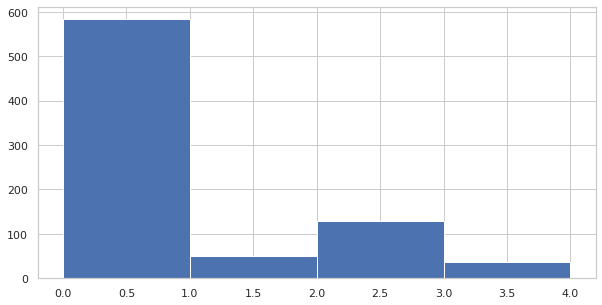

In [ ]:
import matplotlib.pyplot as plt

x = valid_generator.classes
plt.hist(x, bins = 4)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

y_true = valid_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.14575, 0.2, 0.16861894432393348, None)
(0.72875, 0.72875, 0.72875, None)
(0.5310765625, 0.72875, 0.6144052783803327, None)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       583
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00       129
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        14

    accuracy                           0.73       800
   macro avg       0.15      0.20      0.17       800
weighted avg       0.53      0.73      0.61       800



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With class weight:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=250,
                                          validation_data=valid_generator,
                                          validation_steps=50,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1,
                                          class_weight = class_weight ).history

model.save("drive/My Drive/Pattern Recognition/DR models/model_2.h5")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
250/250 [==============================] - 192s 767ms/step - loss: 3.6494 - accuracy: 0.7400 - val_loss: 1.4384 - val_accuracy: 0.6000
Epoch 2/40
250/250 [==============================] - 188s 752ms/step - loss: 3.3264 - accuracy: 0.6400 - val_loss: 1.2476 - val_accuracy: 0.8000
Epoch 3/40
250/250 [==============================] - 187s 746ms/step - loss: 3.7676 - accuracy: 0.4120 - val_loss: 1.4590 - val_accuracy: 0.5800
Epoch 4/40
250/250 [==============================] - 187s 745ms/step - loss: 4.8939 - accuracy: 0.3680 - val_loss: 1.5707 - val_accuracy: 0.2600
Epoch 5/40
250/250 [==============================] - 185s 741ms/step - loss: 3.9068 - accuracy: 0.2680 - val_loss: 1.5218 - val_accuracy: 0.1600

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 6/40
250/250 [==============================] - 185s 740ms/step - loss: 4.0517 - accuracy: 0.2080 - val_loss: 1.5463 - val_accuracy: 0.0800
Epoch 7/40
250/250 [=======================

In [ ]:
predictions = model.predict(test_generator)

In [26]:
# model 2
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.15499398315282792, 0.2, 0.17464406779661015, None)
(0.7749699157641395, 0.7749699157641395, 0.7749699157641396, None)
(0.6005783703394776, 0.7749699157641395, 0.6767194925452283, None)
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       644
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        10

    accuracy                           0.77       831
   macro avg       0.15      0.20      0.17       831
weighted avg       0.60      0.77      0.68       831



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import keras

model = keras.models.load_model("drive/My Drive/Pattern Recognition/DR models/model_10_1.h5")

In [25]:
predictions = model.predict(test_generator)

In [19]:
# model 10, test set oversampled
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.35067768897879675, 0.34582694053391677, 0.34574116370491204, None)
(0.352333746385791, 0.352333746385791, 0.352333746385791, None)
(0.35538450890565954, 0.352333746385791, 0.3510863869491836, None)
              precision    recall  f1-score   support

           0       0.33      0.39      0.36       651
           1       0.34      0.26      0.29       618
           2       0.37      0.41      0.39       571
           3       0.25      0.28      0.27       207
           4       0.46      0.39      0.42       374

    accuracy                           0.35      2421
   macro avg       0.35      0.35      0.35      2421
weighted avg       0.36      0.35      0.35      2421



In [26]:
predictions = model.predict(test_generator)

In [27]:
# model 10_3
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.21298951526680088, 0.14940142777104362, 0.07709935739001483, None)
(0.09626955475330927, 0.09626955475330927, 0.09626955475330927, None)
(0.6745163512665417, 0.09626955475330927, 0.13162496512726984, None)
              precision    recall  f1-score   support

           0       0.84      0.07      0.13       644
           1       0.07      0.04      0.05        57
           2       0.14      0.24      0.18       113
           3       0.00      0.00      0.00         7
           4       0.01      0.40      0.03        10

    accuracy                           0.10       831
   macro avg       0.21      0.15      0.08       831
weighted avg       0.67      0.10      0.13       831



In [ ]:
# model 12
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.1982912660049952, 0.1968518641737086, 0.12443130794228303, None)
(0.20818291215403129, 0.20818291215403129, 0.20818291215403129, None)
(0.6182807750474557, 0.20818291215403129, 0.2881846511514965, None)
              precision    recall  f1-score   support

           0       0.77      0.21      0.33       644
           1       0.07      0.19      0.10        57
           2       0.14      0.18      0.16       113
           3       0.00      0.00      0.00         7
           4       0.02      0.40      0.03        10

    accuracy                           0.21       831
   macro avg       0.20      0.20      0.12       831
weighted avg       0.62      0.21      0.29       831



In [ ]:
# model 11_2 with oversampling
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.3417892574410467, 0.33200091779798313, 0.3334083326051451, None)
(0.343207786711807, 0.343207786711807, 0.343207786711807, None)
(0.3501368098091383, 0.343207786711807, 0.3428719101119621, None)
              precision    recall  f1-score   support

           0       0.33      0.44      0.38       615
           1       0.32      0.29      0.30       608
           2       0.38      0.31      0.34       568
           3       0.21      0.24      0.23       205
           4       0.47      0.38      0.42       367

    accuracy                           0.34      2363
   macro avg       0.34      0.33      0.33      2363
weighted avg       0.35      0.34      0.34      2363



In [ ]:
# model 11_2
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.23354255676519492, 0.303430787434149, 0.2123836216277161, None)
(0.4055354993983153, 0.4055354993983153, 0.4055354993983153, None)
(0.6574886453381429, 0.4055354993983153, 0.4854665065771123, None)
              precision    recall  f1-score   support

           0       0.80      0.45      0.57       644
           1       0.07      0.26      0.11        57
           2       0.21      0.27      0.24       113
           3       0.02      0.14      0.04         7
           4       0.06      0.40      0.11        10

    accuracy                           0.41       831
   macro avg       0.23      0.30      0.21       831
weighted avg       0.66      0.41      0.49       831



In [ ]:
# model 10
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.24430931413363863, 0.35386145239975664, 0.2300609855408962, None)
(0.4055354993983153, 0.4055354993983153, 0.4055354993983153, None)
(0.667902702578615, 0.4055354993983153, 0.4787922385678441, None)
              precision    recall  f1-score   support

           0       0.82      0.42      0.56       644
           1       0.09      0.28      0.13        57
           2       0.20      0.38      0.27       113
           3       0.04      0.29      0.07         7
           4       0.07      0.40      0.12        10

    accuracy                           0.41       831
   macro avg       0.24      0.35      0.23       831
weighted avg       0.67      0.41      0.48       831



In [ ]:
# model 9
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = valid_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.20503090202718927, 0.20493105322206745, 0.2027238799257983, None)
(0.20556107249255212, 0.20556107249255212, 0.20556107249255212, None)
(0.20635208209906558, 0.20556107249255212, 0.20364345541495724, None)
              precision    recall  f1-score   support

           0       0.19      0.20      0.19       534
           1       0.21      0.21      0.21       633
           2       0.21      0.13      0.16       626
           3       0.23      0.26      0.25       661
           4       0.18      0.22      0.20       567

    accuracy                           0.21      3021
   macro avg       0.21      0.20      0.20      3021
weighted avg       0.21      0.21      0.20      3021



In [ ]:
# model 7
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = valid_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.19091801509129527, 0.19684849452583092, 0.11679235738897228, None)
(0.2025, 0.2025, 0.2025, None)
(0.5590815217022712, 0.2025, 0.2678530093855987, None)
              precision    recall  f1-score   support

           0       0.74      0.22      0.34       583
           1       0.07      0.41      0.11        51
           2       0.11      0.03      0.05       129
           3       0.03      0.17      0.05        23
           4       0.02      0.14      0.03        14

    accuracy                           0.20       800
   macro avg       0.19      0.20      0.12       800
weighted avg       0.56      0.20      0.27       800



In [ ]:
# model 6
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = valid_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.1730596489752127, 0.1559277784132989, 0.10468496313686985, None)
(0.1925, 0.1925, 0.19249999999999998, None)
(0.5259551506738639, 0.1925, 0.26162988172978285, None)
              precision    recall  f1-score   support

           0       0.70      0.22      0.34       583
           1       0.05      0.29      0.08        51
           2       0.09      0.03      0.05       129
           3       0.02      0.09      0.03        23
           4       0.02      0.14      0.03        14

    accuracy                           0.19       800
   macro avg       0.17      0.16      0.10       800
weighted avg       0.53      0.19      0.26       800



In [ ]:
preds_classes = np.argmax(predictions, axis=-1)

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

y_true = valid_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.14575, 0.2, 0.16861894432393348, None)
(0.72875, 0.72875, 0.72875, None)
(0.5310765625, 0.72875, 0.6144052783803327, None)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       583
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00       129
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        14

    accuracy                           0.73       800
   macro avg       0.15      0.20      0.17       800
weighted avg       0.53      0.73      0.61       800



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


with batch size = 8:

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=250,
                                          validation_data=valid_generator,
                                          validation_steps=50,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1,
                                          class_weight = class_weight).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
250/250 [==============================] - 1547s 6s/step - loss: 4.1245 - accuracy: 0.2600 - val_loss: 1.6072 - val_accuracy: 0.0200
Epoch 2/40
250/250 [==============================] - 1512s 6s/step - loss: 4.1367 - accuracy: 0.0710 - val_loss: 1.6108 - val_accuracy: 0.0250
Epoch 3/40
250/250 [==============================] - 1509s 6s/step - loss: 3.9207 - accuracy: 0.2875 - val_loss: 1.5772 - val_accuracy: 0.2775
Epoch 4/40
250/250 [==============================] - 1501s 6s/step - loss: 4.1891 - accuracy: 0.1120 - val_loss: 1.6189 - val_accuracy: 0.0350
Epoch 5/40
250/250 [==============================] - 1495s 6s/step - loss: 4.0077 - accuracy: 0.1345 - val_loss: 1.6154 - val_accuracy: 0.0225
Epoch 6/40
250/250 [==============================] - 1497s 6s/step - loss: 4.3043 - accuracy: 0.1510 - val_loss: 1.5939 - val_accuracy: 0.2250

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/40
250/250 [==============================] - 1

In [ ]:
model.save("drive/My Drive/Pattern Recognition/DR models/model_3.h5")

In [33]:
model = load_model("drive/My Drive/Pattern Recognition/DR models/model_3.h5")

In [34]:
predictions = model.predict(test_generator)

In [35]:
# model 3
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

preds_classes = np.argmax(predictions, axis=-1)

y_true = test_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.20320601783289724, 0.24076792597114177, 0.08811629715213684, None)
(0.11311672683513839, 0.11311672683513839, 0.11311672683513839, None)
(0.6326536693804442, 0.11311672683513839, 0.16268673327001865, None)
              precision    recall  f1-score   support

           0       0.79      0.10      0.18       644
           1       0.05      0.18      0.08        57
           2       0.14      0.10      0.12       113
           3       0.01      0.43      0.02         7
           4       0.02      0.40      0.04        10

    accuracy                           0.11       831
   macro avg       0.20      0.24      0.09       831
weighted avg       0.63      0.11      0.16       831



In [ ]:
# model 8

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

y_true = valid_generator.classes
y_pred = preds_classes

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

(0.20192078562872245, 0.20010885526063343, 0.19809580028422763, None)
(0.19953130231001004, 0.19953130231001004, 0.19953130231001004, None)
(0.20391179028360706, 0.19953130231001004, 0.19864350364876682, None)
              precision    recall  f1-score   support

           0       0.20      0.21      0.20       575
           1       0.20      0.26      0.23       593
           2       0.24      0.15      0.19       651
           3       0.21      0.20      0.20       649
           4       0.16      0.18      0.17       519

    accuracy                           0.20      2987
   macro avg       0.20      0.20      0.20      2987
weighted avg       0.20      0.20      0.20      2987

